In [1]:
import os
import yt
import numpy as np
import matplotlib.pyplot as plt
import h5py
from tqdm import trange
from mpl_toolkits.axes_grid1 import AxesGrid
from utils import grabFileSeries, get_simulation_time, change_in_box
from utils import draw_xy_box, parse_input_file, div2D, dFdx, dFdy, rolling_average

print(yt.__version__)
os.system("python --version")
yt.set_log_level(50)        
"""
Possible values of set_log_level by increasing level:
        0 or "notset"
        1 or "all"
        10 or "debug"
        20 or "info"
        30 or "warning"
        40 or "error"
        50 or "critical"
"""

## Checking derived or innate field lists
# ds = ts[0]
# ds.derived_field_list
# print(ds.field_list)
# ad = ds.all_data()
# test = np.array(ad[('athena_pp', 'vel1')])
## Defining field variables so quickly changing them is easier
keoverme, keoverte = ('gas', 'KEoverME'), ('gas', 'KEoverTE')
current_eta_z = ('gas', 'current_eta_z')
div_MFT = ("gas", "magnetic_flux_transport_divergence")
ByoverBx = ("gas", "ByoverBx")
curlBz = ("parthenon", "curlBz")

Bcc1, Bcc2, Bcc3 = ('athena_pp', 'Bcc1'), ('athena_pp', 'Bcc2'), ('athena_pp', 'Bcc3')
cell_volume = ('athena_pp', 'cell_volume')
dx, dy, dz = ('athena_pp', 'dx'), ('athena_pp', 'dy'), ('athena_pp', 'dz')
Etot = ('athena_pp', 'Etot')
path_element_x, path_element_y, path_element_z = ('athena_pp', 'path_element_x'), ('athena_pp', 'path_element_y'), ('athena_pp', 'path_element_z')
press, rho = ('athena_pp', 'press'), ('athena_pp', 'rho')
vel1, vel2, vel3 = ('athena_pp', 'vel1'), ('athena_pp', 'vel2'), ('athena_pp', 'vel3')
volume, x, y, z = ('athena_pp', 'volume'), ('athena_pp', 'x'), ('athena_pp', 'y'), ('athena_pp', 'z')
alfven_speed, angular_momentum_magnitude = ('gas', 'alfven_speed'), ('gas', 'angular_momentum_magnitude')
angular_momentum_x, angular_momentum_y, angular_momentum_z = ('gas', 'angular_momentum_x'), ('gas', 'angular_momentum_y'), ('gas', 'angular_momentum_z')
averaged_density, baroclinic_vorticity_magnitude = ('gas', 'averaged_density'), ('gas', 'baroclinic_vorticity_magnitude')
baroclinic_vorticity_x, baroclinic_vorticity_y, baroclinic_vorticity_z = ('gas', 'baroclinic_vorticity_x'), ('gas', 'baroclinic_vorticity_y'), ('gas', 'baroclinic_vorticity_z')
cell_mass, cell_volume = ('gas', 'cell_mass'), ('gas', 'cell_volume')
courant_time_step, density = ('gas', 'courant_time_step'), ('gas', 'density')
density_gradient_magnitude, density_gradient_x, density_gradient_y, density_gradient_z = ('gas', 'density_gradient_magnitude'), ('gas', 'density_gradient_x'), ('gas', 'density_gradient_y'), ('gas', 'density_gradient_z')
dx_gas, dy_gas, dynamical_time, dz_gas = ('gas', 'dx'), ('gas', 'dy'), ('gas', 'dynamical_time'), ('gas', 'dz')
jeans_mass, kT, kinetic_energy_density, lorentz_factor = ('gas', 'jeans_mass'), ('gas', 'kT'), ('gas', 'kinetic_energy_density'), ('gas', 'lorentz_factor')
mach_alfven, mach_number = ('gas', 'mach_alfven'), ('gas', 'mach_number')
magnetic_energy_density, magnetic_field_los, magnetic_field_magnitude = ('gas', 'magnetic_energy_density'), ('gas', 'magnetic_field_los'), ('gas', 'magnetic_field_magnitude')
magnetic_field_strength, magnetic_field_x, magnetic_field_y, magnetic_field_z = ('gas', 'magnetic_field_strength'), ('gas', 'magnetic_field_x'), ('gas', 'magnetic_field_y'), ('gas', 'magnetic_field_z')
magnetic_pressure, mass, mean_molecular_weight = ('gas', 'magnetic_pressure'), ('gas', 'mass'), ('gas', 'mean_molecular_weight')
momentum_density_x, momentum_density_y, momentum_density_z = ('gas', 'momentum_density_x'), ('gas', 'momentum_density_y'), ('gas', 'momentum_density_z')
momentum_x, momentum_y, momentum_z = ('gas', 'momentum_x'), ('gas', 'momentum_y'), ('gas', 'momentum_z')
number_density, plasma_beta = ('gas', 'number_density'), ('gas', 'plasma_beta')
pressure, pressure_gradient_magnitude, pressure_gradient_x, pressure_gradient_y, pressure_gradient_z = ('gas', 'pressure'), ('gas', 'pressure_gradient_magnitude'), ('gas', 'pressure_gradient_x'), ('gas', 'pressure_gradient_y'), ('gas', 'pressure_gradient_z')
relative_magnetic_field_x, relative_magnetic_field_y, relative_magnetic_field_z = ('gas', 'relative_magnetic_field_x'), ('gas', 'relative_magnetic_field_y'), ('gas', 'relative_magnetic_field_z')
relative_velocity_x, relative_velocity_y, relative_velocity_z = ('gas', 'relative_velocity_x'), ('gas', 'relative_velocity_y'), ('gas', 'relative_velocity_z')
shear, shear_criterion, shear_mach, sound_speed = ('gas', 'shear'), ('gas', 'shear_criterion'), ('gas', 'shear_mach'), ('gas', 'sound_speed')
specific_angular_momentum_magnitude, specific_angular_momentum_x, specific_angular_momentum_y, specific_angular_momentum_z = ('gas', 'specific_angular_momentum_magnitude'), ('gas', 'specific_angular_momentum_x'), ('gas', 'specific_angular_momentum_y'), ('gas', 'specific_angular_momentum_z')
specific_thermal_energy, temperature, velocity_los = ('gas', 'specific_thermal_energy'), ('gas', 'temperature'), ('gas', 'velocity_los')
velocity_magnitude, velocity_x, velocity_y, velocity_z = ('gas', 'velocity_magnitude'), ('gas', 'velocity_x'), ('gas', 'velocity_y'), ('gas', 'velocity_z')
volume, vorticity_magnitude, vorticity_squared = ('gas', 'volume'), ('gas', 'vorticity_magnitude'), ('gas', 'vorticity_squared')
vorticity_x, vorticity_y, vorticity_z = ('gas', 'vorticity_x'), ('gas', 'vorticity_y'), ('gas', 'vorticity_z')
x_gas, y_gas, z_gas = ('gas', 'x'), ('gas', 'y'), ('gas', 'z')

## Defining Dictionary for easy access
# scratchPath = "/mnt/gs21/scratch/freem386/"
directoryDict = {'rh1': 'recon_harris1/', 'rw1': 'recon_wire1/', 'rh2': 'recon_harris2/',
                 'rh3': 'recon_harris3/', 'rg1': 'recon_GEM1/', 'rb1': 'recon_bhat1/', 
                 'rb2': 'recon_bhat2/', 'rb3': 'recon_bhat3/',
                 'rf1': 'recon_freem1/', 'rf2': 'recon_freem2/', 'rf3': 'recon_freem3/',
                 'rf4': 'recon_freem4/', 'rf5': 'recon_freem5/', 'rf6': 'recon_freem6/',
                 'rf7': 'recon_freem7/', 'rf8': 'recon_freem8/',
                 'np0': 'non_periodic_test/', 'np2': 'non_periodic_test2/',
                 'rs1': 'recon_fast1/', 'rs2': 'recon_fast2/', 'rs3': 'recon_fast3/',
                 'rs4': 'recon_fast4/', 'rs6': 'recon_fast6/',
                 'rt1': 'recon_test1/', 'rt2': 'recon_test2/', 'rt3': 'recon_test3/', 'rt4': 'recon_test4/',
                 'rt5': 'recon_test5/', 'rt6': 'recon_test6/', 'rt7': 'recon_test7/', 'rt8': 'recon_test8/',
                 'st3': 'scaling_test_e3/', 'st5': 'scaling_test_e5/', 'st7': 'scaling_test_e7/',
                 'r1': 'reduction1/', 'r2': 'reduction2/', 'r3': 'reduction3/', 'r4': 'reduction4/',
                 'temp': "template/",
                 'ftest': "forcetest/",
                 '1e-2': "vary_eta/eta_1e-2/", '2e-2': "vary_eta/eta_2e-2/",'5e-2': "vary_eta/eta_5e-2/",
                 '1e-3': "vary_eta/eta_1e-3/", '2e-3': "vary_eta/eta_2e-3/",'5e-3': "vary_eta/eta_5e-3/",
                 '1e-4': "vary_eta/eta_1e-4/", '2e-4': "vary_eta/eta_2e-4/",'5e-4': "vary_eta/eta_5e-4/",
                 '1e-5': "vary_eta/eta_1e-5/", '2e-5': "vary_eta/eta_2e-5/",'5e-5': "vary_eta/eta_5e-5/",
                 '1e-6': "vary_eta/eta_1e-6/", '2e-6': "vary_eta/eta_2e-6/",'5e-6': "vary_eta/eta_5e-6/",
                 '1e-7': "vary_eta/eta_1e-7/", '2e-7': "vary_eta/eta_2e-7/",'5e-7': "vary_eta/eta_5e-7/",
                 'ff17': "vary_eta_force_free_IC/1e-7/", 'ff27': "vary_eta_force_free_IC/2e-7/", 'ff57': "vary_eta_force_free_IC/5e-7/",
                 'ff16': "vary_eta_force_free_IC/1e-6/", 'ff26': "vary_eta_force_free_IC/2e-6/", 'ff56': "vary_eta_force_free_IC/5e-6/",
                 'ff15': "vary_eta_force_free_IC/1e-5/", 'ff25': "vary_eta_force_free_IC/2e-5/", 'ff55': "vary_eta_force_free_IC/5e-5/",
                 'ff14': "vary_eta_force_free_IC/1e-4/", 'ff24': "vary_eta_force_free_IC/2e-4/", 'ff54': "vary_eta_force_free_IC/5e-4/",
                 'ff13': "vary_eta_force_free_IC/1e-3/", 'ff23': "vary_eta_force_free_IC/2e-3/", 'ff53': "vary_eta_force_free_IC/5e-3/",
                 'gt': 'ghost_test/', 'cf': 'coarse_forced_recon/',
                 'tapk': "testAPK/", 'bapk': "breakAPK/", 'tapk3': "testAPK3/",
                 'debug': "debug/",
                 'rapk': 'recon_apk/', 'papk': 'plasmoid_apk/', 'arapk': 'adaptive_recon_APK/', 'bapk3': 'breakAPK3D/',
                 'bapkc': 'breakAPK_CPU_test/', 'ptest': "periodic_test/", 'tlin': "test_linear/",
                 'nsrt1': 'no_shock_reconnection_test1/', 
                 'spitzertestspitzer': 'spitzer_test/spitzer/', 'spitzertestnodiffusion': 'spitzer_test/no_diffusion/'
                 }

4.4.0
Python 3.12.4



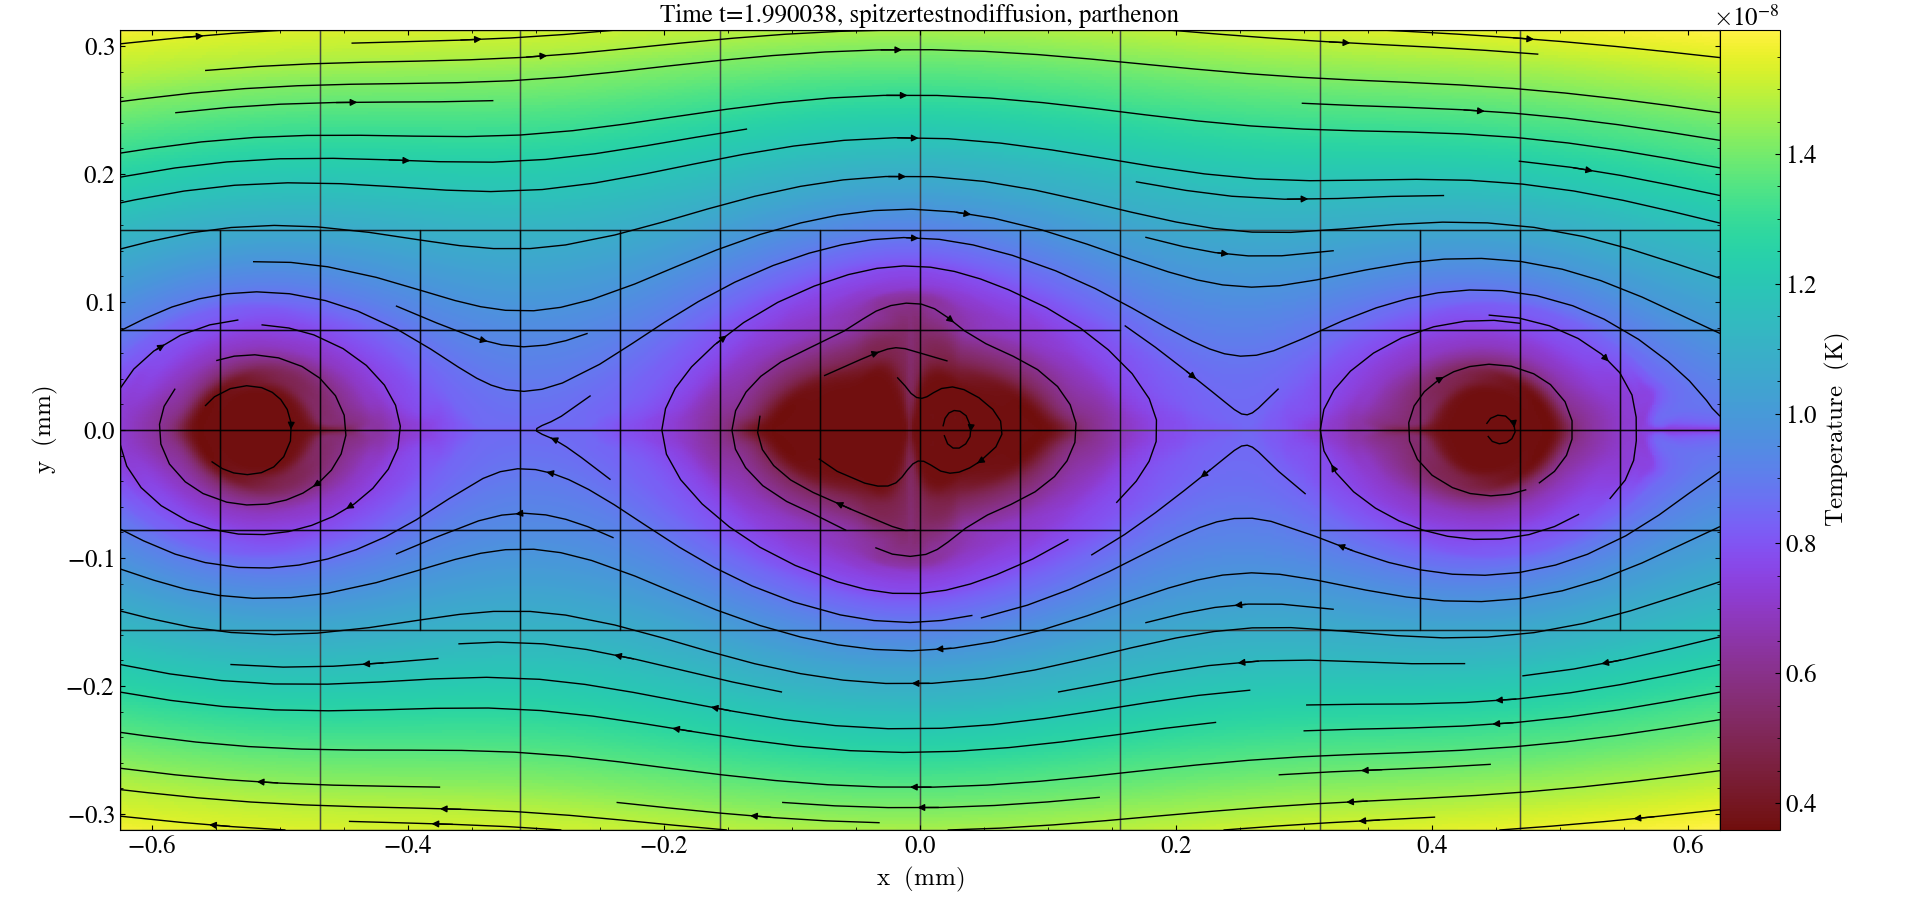

In [4]:
## Plotting a single dataset
index = 199
dictkey, basename = "spitzertestnodiffusion", "parthenon"
# inputname = "periodic_reconnection.in"
output_type = "out0"   # Other common: out2, prim
fileseries = grabFileSeries(directoryDict[dictkey], index, basename=basename, outputnum=output_type, extension="phdf")
ts = yt.DatasetSeries(fileseries)
time = get_simulation_time(fileseries[index])
ds = ts[index]
# print(fileseries)

field = temperature
p = yt.SlicePlot(ds, "z", field)
p.set_log(field, False)

p.set_figure_size(16)
p.zoom(2**4)
# p.pan((1, 0))
# p.annotate_velocity()
p.annotate_streamlines(("gas", "magnetic_field_x"), ("gas", "magnetic_field_y"), color='black')
p.annotate_grids()

p.annotate_title(f'Time t={time:.6f}, {dictkey}, {basename}')
p

In [6]:
# p.save(f"figures/{dictkey}_{index}_zoom.png")

['figures/spitzertestspitzer_199_zoom.png']

In [7]:
plt.close("all")